Config

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

In [2]:
config = {
    # config for the neural network
    "nn": {
        "window": 50, # this is also the window, window size or entries used to predict the future price
        "nLayers": 2, # 2
        "neurons": 256, # 256
        "nFeatures": 5,
        "dropout": 0.2,
        "lossFunc": "huber_loss", # "huber_loss" Huber looss is better to give outliers some weight but not too much, which can be good for predicting asset prices?
        "optimizer": "adam", # "adam"
        "layerType": LSTM, # could set it upt to be a list of the layers that need to be generated [LSTM LSTM] 2 hidden layers 
    },
    "data": {
        "ticker": "AMZN", # "TSLA" "AMZN" "AAPL" "NVDA" "AMD"
        "offset": pd.DateOffset(years = 3, months = 0, days = 0),
        "lookahead": 2,
        "validation": 0.1, # percentage of training data to be used as validation
        "testSize": 0.1, # to test on 
        "scale": True,
        "scaler": preprocessing.MinMaxScaler(),
        "inputs": ['adjclose', 'volume', 'open', 'high', 'low'],
    },
    "training": {
        "batch_size": 64, # 64
        "num_epoch": 200, # 500
    }
}
# DISPLAY AROUGH ESTIMATE OF HOW MANY DAYS WILL BE USED FOR EACH SECTION
damping = 0.9 # some extra damping for extra days that data isn't collected

offset = config["data"]["offset"]
ts1 = pd.Timestamp('2023-02-25')
ts2 = ts1 + offset
td = ts2 - ts1
days_offset = int(td.days/7*5*damping) # find out the roungh amount of days imported
print(f"{days_offset} Total days used will be roughly imported\n")
print(f"{days_offset* (1-config['data']['validation']-config['data']['testSize'])} Days used for training")
print(f"{days_offset*config['data']['validation']} Days used for validation")
print(f"{days_offset*config['data']['testSize']} Days used for testing")

from tensorflow.keras import models
from tensorflow.keras.layers import Dropout, LSTM, Dense


"""
HERE mean_absolute_error CAN BE REPLACED BY mse?
Also need to have a look at bidirectional network and how that works and so forth

"""
def generateModel(
    window,
    n_layers=2,
    neurons=256,
    n_features=5,
    dropout=0.3,
    loss="mean_absolute_error",
    optimizer="rmsprop",
    layerType=LSTM
    ):
    # generate a keras model to linearly group a stasck of layers
    model = models.Sequential()
    # repeat for each layer
    for layer in range(n_layers):
        # check for first layer
        if layer == 0:
            """NEED TO FIGURE OUT THE DIFFERENE BETWEEN THEESE TWO LINES OF CODE, INPUT SHAPE AND BATCH INPUT SHAPE"""
            model.add(LSTM(neurons, return_sequences=True, input_shape=(window, n_features)))
            # model.add(layerType(neurons, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        # check for final layer
        elif layer == n_layers - 1:
            model.add(layerType(neurons, return_sequences=False))
        # middle/hidden layers
        else:
            model.add(layerType(neurons, return_sequences=True))

        # add dropout after each layer
        """ this layer helps prevent over fitting
        The Dropout layer randomly sets input units to 0
        with a frequency of rate at each step during training time,
        which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate)
        such that the sum over all inputs is unchanged."""
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    # compile the model once it has be compelted
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

# Import yfinance package (NEED OT DOUBLE CHEKC IF THIS IS ACTUALLY A MODEL THAT CAN BE USED)

# import yfinance as yf # make sure to unisntall if this isn't used in the future
from yahoo_fin import stock_info
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn import preprocessing

from collections import deque

def getData(
    ticker,
    offset
    ):
    # setup the start date and end date
    startDate = (datetime.now() - offset).date()
    endDate = datetime.now().date()
    # Get the data
    stocks = stock_info.get_data(ticker, startDate, endDate)
    # display how many days of data are being used for this
    print(f"{ticker} data has been imported between {startDate} and the {endDate}, for a total of {len(stocks)} days of data")
    # print(f"Each day contains the prices for: {stocks.columns}")
    return stocks

def setupData(
    stocks, # data to be reshaped
    window = 50, # the number of days used to predic the next value (window size or lookback perdiod)
    predAhead = 10, # the number of days ahead that you are tyring to predict
    validationSize = 0.1, # amount of data out of the training data to be used as validation
    testSize = 0.2, # the amount of data that will be  used for testing e.g. 0.2 -> 20%
    scale = True, # minmaxscaler
    scaler = preprocessing.MinMaxScaler(), # the scaler to be used
    inputs = ['adjclose', 'volume', 'open', 'high', 'low']
    ):
    # Setup a dictionary to store all the data
    data = {}
    # copy the data frame
    data["raw"] = stocks.copy()

    """This is something that really needs to be fixed in the future"""
    # I HAVE TO COPY THE STOCKS SO THAT THE ORIGINAL ONES AREN'T RETURNED? WHAT IS THIS ABOUT
    stocks = stocks.copy()
    



    # should we scale down between 0 and 1? It can make analysis easier
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in inputs:
            # scale the columns
            stocks[column] = scaler.fit_transform(np.expand_dims(stocks[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        data["column_scaler"] = column_scaler

    # create input a variable with x and y
    x = []
    y = []
    ydates = []
    for i in range(len(stocks)-window-predAhead+1):
        x.append(np.array(stocks[inputs].values[i:i+window]))
        y.append(stocks["adjclose"].values[i+window+predAhead-1])
        ydates.append(stocks.index[i+window+1])
    # convert into numpy arrays
    x = np.array(x)
    y = np.array(y)

    # store x and y into the data dictionary
    data["x"] = x
    data["y"] = y
    data["ydates"] =  ydates

    # split the dataset into training & testing sets by date
    # make sure to convert to an integer so that it can be used for indexing
    trainSamples = int((1 - testSize - validationSize) * len(x))
    valSamples = int(validationSize * len(x))
    data["xtrain"] = x[:trainSamples]
    data["ytrain"] = y[:trainSamples]

    data["xval"] = x[trainSamples:trainSamples+valSamples]
    data["yval"] = y[trainSamples:trainSamples+valSamples]

    data["xtest"]  = x[trainSamples+valSamples:]
    data["ytest"]  = y[trainSamples+valSamples:]
    
    data["trainDates"] = ydates[:trainSamples]
    data["valDates"] = ydates[trainSamples:trainSamples+valSamples]
    data["testDates"] = ydates[trainSamples+valSamples:]

    return data


704 Total days used will be roughly imported

563.2 Days used for training
70.4 Days used for validation
70.4 Days used for testing


Data

AMZN data has been imported between 2020-03-08 and the 2023-03-08, for a total of 755 days of data


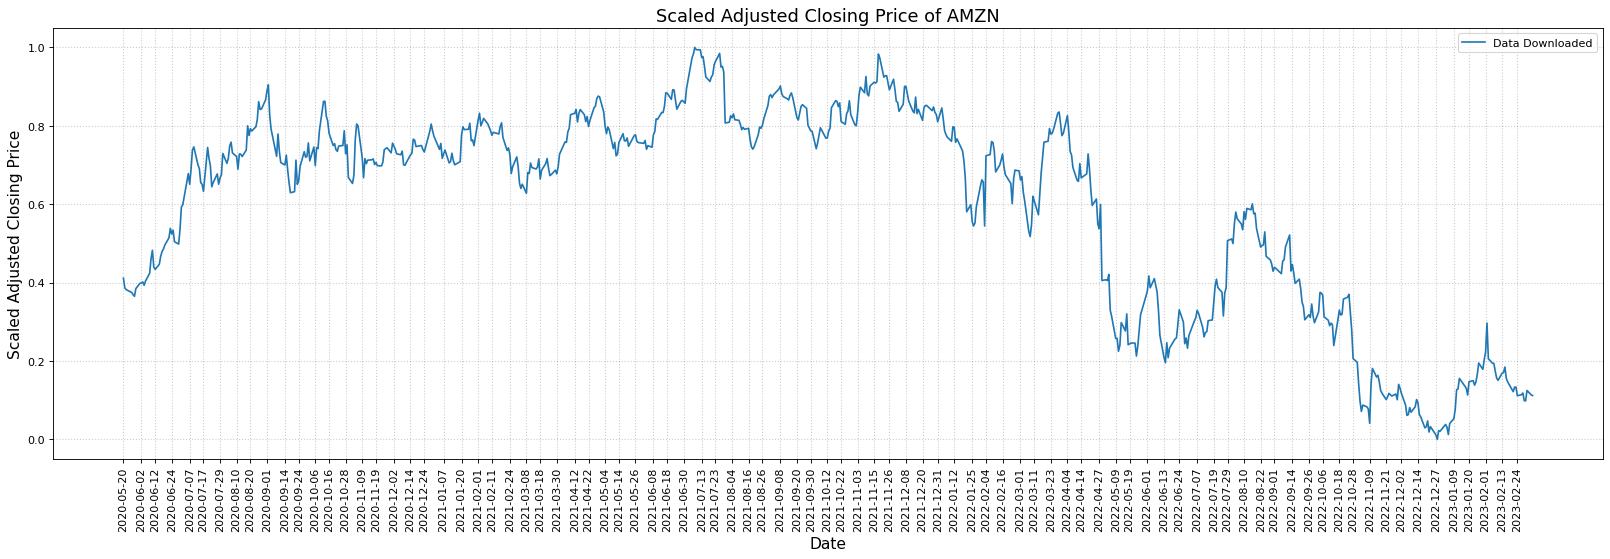

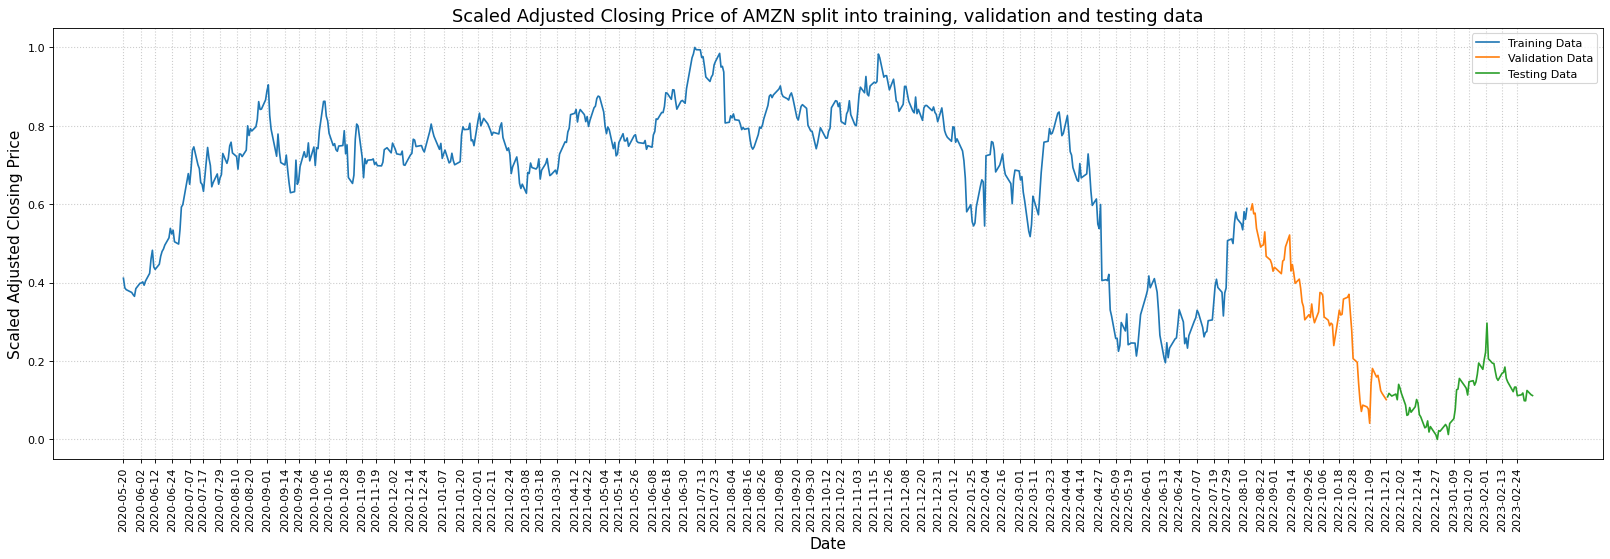

In [3]:
# download data form yt
stocks = getData(config["data"]["ticker"], config["data"]["offset"])


# process the data
config["data"]["scale"] = True
data = setupData(stocks, config["nn"]["window"], config["data"]["lookahead"], config["data"]["validation"], config["data"]["testSize"], config["data"]["scale"], config["data"]["scaler"], config["data"]["inputs"])
data.keys()

import matplotlib.pyplot as plt

lines = 100
fig = plt.figure(figsize=(25, 7), dpi=80)
# plot all the different lines
plt.plot(data["ydates"], data["y"])

step = round(len(data["raw"]["adjclose"].keys())/lines)
plt.xticks(data["ydates"][::step], rotation='vertical') 
# Plot the grid lines
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
scaled = lambda x: "Scaled " if x == True else ""
plt.title(f"{scaled(config['data']['scale'])}Adjusted Closing Price of {config['data']['ticker']}", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel(f"{scaled(config['data']['scale'])}Adjusted Closing Price", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.legend("Data Downloaded".split(","))
# show the plot
plt.show()

plots = "trainDates ytrain,valDates yval,testDates ytest"
lines = 100
fig = plt.figure(figsize=(25, 7), dpi=80)
# plot all the different lines
for plot in plots.split(","):
    x, y = plot.split()
    plt.plot(data[f"{x}"], data[f"{y}"])
step = round(len(data["raw"]["adjclose"].keys())/lines)
plt.xticks(data["ydates"][::step], rotation='vertical') 
# Plot the grid lines
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
scaled = lambda x: "Scaled " if x == True else ""
plt.title(f"{scaled(config['data']['scale'])}Adjusted Closing Price of {config['data']['ticker']} split into training, validation and testing data", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel(f"{scaled(config['data']['scale'])}Adjusted Closing Price", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.legend("Training Data,Validation Data,Testing Data".split(","))
# show the plot
plt.show()



Training

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

model_name = "trials"

# create a new model to be trained
model = generateModel(
    config["nn"]["window"],
    config["nn"]["nLayers"],
    config["nn"]["neurons"],
    n_features= config["nn"]["nFeatures"],
    dropout= config["nn"]["dropout"],
    loss= config["nn"]["lossFunc"],
    optimizer= config["nn"]["optimizer"],
    layerType= config["nn"]["layerType"]
    )

checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

# Train the model by using the funciton fit
history = model.fit(data["xtrain"], data["ytrain"],
                    batch_size=config["training"]["batch_size"],
                    epochs=config["training"]["num_epoch"],
                    validation_data=(data["xval"], data["yval"]),
                    verbose=1) # should be able to chance verbose to 100 to display every 100 but doesn't seem to work
                    # callbacks=[checkpointer, tensorboard],


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-08 15:06:33.643727: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-08 15:06:33.644340: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/200


2023-03-08 15:06:34.211706: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-08 15:06:35.459569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-08 15:06:35.684707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-08 15:06:35.835880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-08 15:06:36.040726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/9 [==>...........................] - ETA: 17s - loss: 0.3166 - mean_absolute_error: 0.7738

2023-03-08 15:06:36.266682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.0889 - mean_absolute_error: 0.3385

2023-03-08 15:06:37.435465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-08 15:06:37.508952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-08 15:06:37.598437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 4s 176ms/step - loss: 0.0889 - mean_absolute_error: 0.3385 - val_loss: 0.0045 - val_mean_absolute_error: 0.0798
Epoch 2/200
9/9 [==============================] - 0s 39ms/step - loss: 0.0124 - mean_absolute_error: 0.1292 - val_loss: 0.0036 - val_mean_absolute_error: 0.0658
Epoch 3/200
9/9 [==============================] - 0s 38ms/step - loss: 0.0062 - mean_absolute_error: 0.0930 - val_loss: 0.0086 - val_mean_absolute_error: 0.1136
Epoch 4/200
9/9 [==============================] - 0s 40ms/step - loss: 0.0043 - mean_absolute_error: 0.0727 - val_loss: 0.0046 - val_mean_absolute_error: 0.0763
Epoch 5/200
9/9 [==============================] - 0s 42ms/step - loss: 0.0035 - mean_absolute_error: 0.0667 - val_loss: 0.0073 - val_mean_absolute_error: 0.1024
Epoch 6/200
9/9 [==============================] - 0s 38ms/step - loss: 0.0030 - mean_absolute_error: 0.0581 - val_loss: 0.0048 - val_mean_absolute_error: 0.0785
Epoch 7/200
9/9 [======================

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.088942,0.338500,0.004485,0.079794
1,0.012417,0.129159,0.003626,0.065783
2,0.006198,0.093004,0.008573,0.113645
3,0.004327,0.072712,0.004566,0.076253
4,0.003522,0.066736,0.007276,0.102357
...,...,...,...,...
195,0.001186,0.036880,0.001979,0.050951
196,0.001213,0.037779,0.001743,0.047565
197,0.001167,0.037219,0.001981,0.050950
198,0.001186,0.038179,0.001856,0.049267


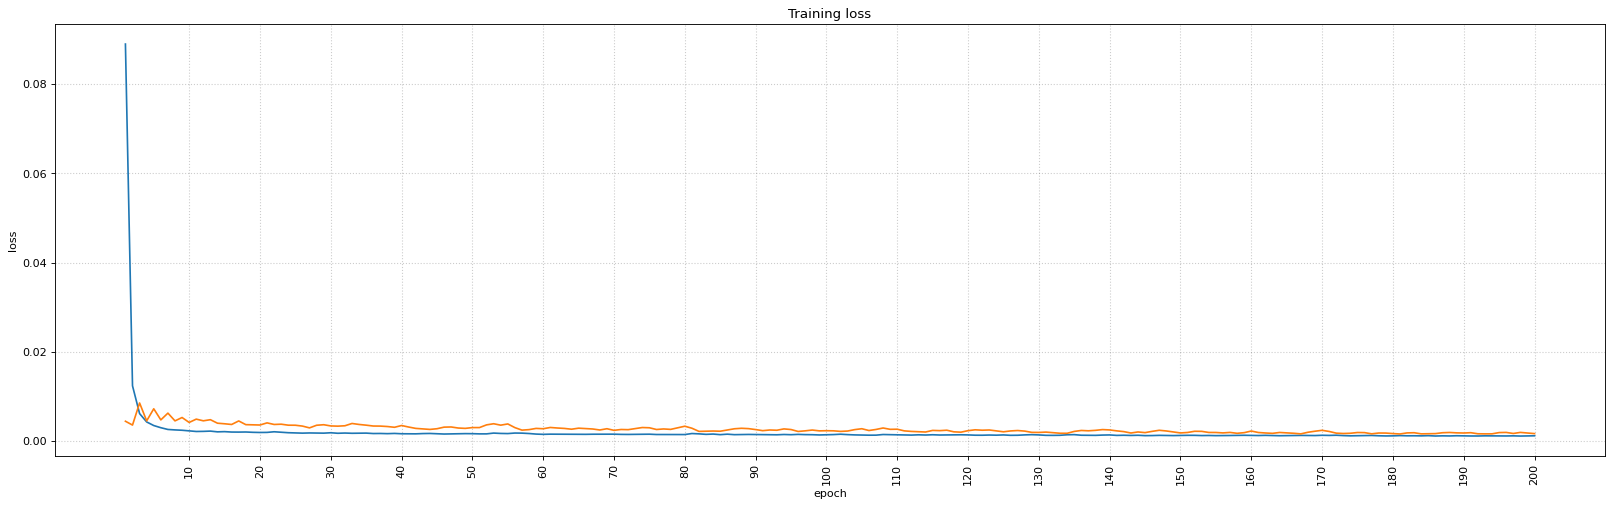

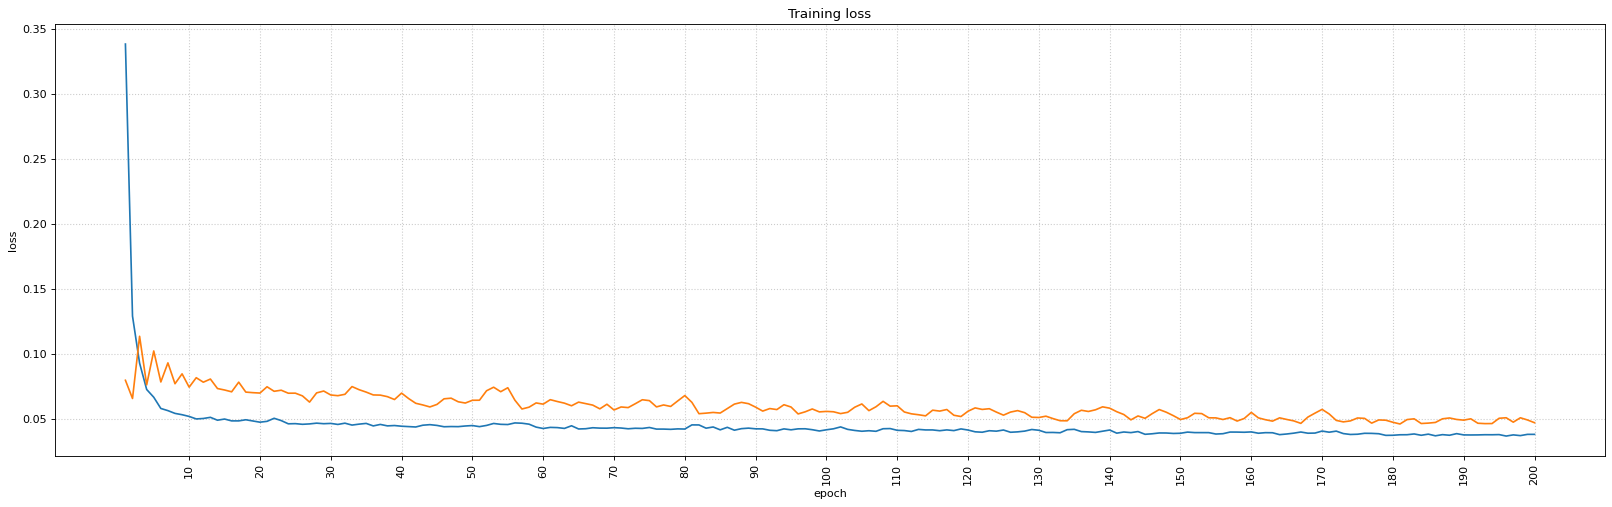

In [5]:
train_history = pd.DataFrame(history.history)
display(train_history)


fig = plt.figure(figsize=(25, 7), dpi=80)
plt.plot(range(1,config["training"]["num_epoch"]+1), train_history['loss'])
plt.plot(range(1,config["training"]["num_epoch"]+1), train_history['val_loss'])
# train_history.plot(figsize=(20,7))
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(10,config["training"]["num_epoch"]+1,10), rotation='vertical') 
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
plt.show()

fig = plt.figure(figsize=(25, 7), dpi=80)
plt.plot(range(1,config["training"]["num_epoch"]+1), train_history['mean_absolute_error'])
plt.plot(range(1,config["training"]["num_epoch"]+1), train_history['val_mean_absolute_error'])
# train_history.plot(figsize=(20,7))
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(10,config["training"]["num_epoch"]+1,10), rotation='vertical') 
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
plt.show()


Analysis

In [6]:
# Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge
def calculate_krr(_data, _scaled):
    krr = KernelRidge(alpha=0.1, kernel='rbf') # why is rbf been used here? and what does the alpha control
    # Train the model on the training data
    krr.fit(_data['xtrain'][:, -1, :], _data['ytrain'])
    # Make predictions on the test data
    pred_krr = krr.predict(_data['xtest'][:, -1, :])
    if _scaled:
        pred_krr = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_krr, axis=0)))
    return pred_krr
# Simple Moving Average
def calculate_ma(_data, _scaled):
    # calcualte the price using a simple moving average
    pred_ma = np.mean(_data["xtest"], axis = 1)
    pred_ma = pred_ma[:, 0] # take only the adjclose price out
    if _scaled:
        pred_ma = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ma, axis=0)))
    return pred_ma
# Exponentila Moving Average
def calculate_ema(_data, _scaled, _window):
    # calculate the price using exponential moving average
    pred_ema = _data["xtest"][:, :, 0] # only take the 
    # pred_EMA = np.squeeze(config["data"]["scaler"].inverse_transform(pred_EMA))
    weights = np.exp(np.linspace(-1, 0, _window))
    weights /= weights.sum()
    pred_ema = pred_ema@weights
    if _scaled:
        pred_ema = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ema, axis=0)))
    return pred_ema

config['data']['scale']
# copmare each network against each other
predictions = {}
y = data["ytest"]

# if scaled
if config['data']['scale']:
    y = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(y, axis=0)))
# needs to be updated

predictions["net"] = model.predict(data["xtest"])
# if the data is scaled
if config['data']['scale']:
    predictions["net"] = np.squeeze(config["data"]["scaler"].inverse_transform(model.predict(data["xtest"])))
# needs to be updated

if 1:
    # add the other methods to compare against
    predictions["krr"] = calculate_krr(data, config['data']['scale'])
    predictions["ma"] = calculate_ma(data, config['data']['scale'])
    predictions["ema"] = calculate_ema(data, config['data']['scale'], config['nn']['window'])



# plot_predictions(data["testDates"], y, predictions, section, comb['dataset'])
# calc_stats(y, predictions, comb["networks"])
# store the predictions made
# break

2023-03-08 15:07:49.042592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-08 15:07:49.109000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-08 15:07:49.200023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 17ms/step


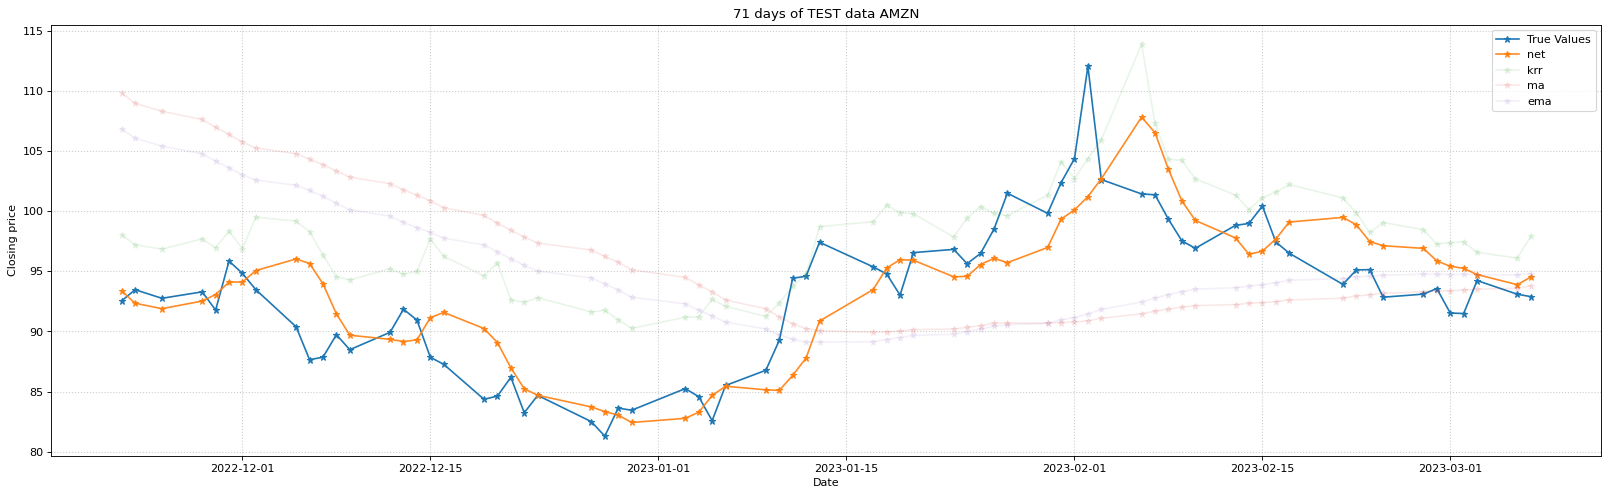

,net,krr,ma,ema
MSE,12.712242,35.388660,104.508070,76.509306
RMSE,3.565423,5.948837,10.222919,8.746960
MAE,2.798490,5.218529,8.849098,7.653895
MAPE,2.982071,5.754350,9.640493,8.303584
DA,0.414286,0.457143,0.500000,0.485714
R²,0.652607,0.032920,-1.855935,-1.090801


In [7]:
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

# MAKE A FUNCTION FOR EACH COMPARISON TOOL
# Mean Squared Error
calc_mse = lambda y_true, y_pred: np.mean((y_true-y_pred)**2)
# Root Mean Squared Error
calc_rmse = lambda y_true, y_pred: np.sqrt(np.mean((y_true-y_pred)**2))
# Mean Absolute Error
calc_mae = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred)))
# Mean Absolute Percentage Error
calc_mape = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred) / y_true))*100
# Directional accuracy
calc_da = lambda y_true, y_pred: np.mean([(y_true[i+1]-y_true[i])*(y_pred[i+1]-y_pred[i]) > 0 for i in range(len(y_true)-1)])
# Coefficient of determination R²
calc_cod = lambda y_true, y_pred: 1 - (sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2))
# calculate the statistics
def calc_stats(_actual, _predictions, _nets = []):
    d = {}
    for net, pred in enumerate(_predictions):
        prediction = _predictions[pred]
        key = pred
        if pred in _nets:
            key = "net" + str(net)
            print(key, "-", pred) # show the network config
        # go throught the selected methods and get results
        d[key] = [func(_actual, prediction) for func in (calc_mse, calc_rmse, calc_mae, calc_mape, calc_da, calc_cod)]
    # create a dataframe from the information
    df = pd.DataFrame(d)
    df.index = ['MSE', 'RMSE', 'MAE', 'MAPE', 'DA', 'R²'] # set the index of the dataframe
    display(df) # display the dataframe
    return df

# to plot results
def plot_predictions(_dates, _y, _predictions, _dataset, _section = 'Test', _highlight = []):
    # plot the results
    fig = plt.figure(figsize=(25, 7), dpi=80)
    # plot the true values
    plt.plot(_dates, _y, "*-", label = "True Values")
    # plot all the predictions
    for idx, pred in enumerate(_predictions):
        if idx in _highlight:
            alpha = 0.9
        elif not _highlight: # if the list is empty
            alpha = 0.4
        else:
            alpha = 0.1
        plt.plot(_dates, _predictions[pred], "*-", label = pred, alpha = alpha)
    plt.legend() # show the labels
    plt.title(f"{len(_y)} days of {_section.upper()} data {_dataset}")
    plt.xlabel("Date")
    plt.ylabel("Closing price")
    # plt.xticks(_dates, rotation = "vertical")
    plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
    plt.show()

# generate the file name to save all of the results
file_name = datetime.now()
file_name = str(file_name).replace(':', '_').split('.')
file_name = 'training ' + file_name[0] + '.pkl'


y = data["ytest"]

# if scaled
if config['data']['scale']:
    y = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(y, axis=0)))

plot_predictions(data["testDates"], y, predictions, config['data']['ticker'], "Test", [0])
stats = calc_stats(y, predictions)

    # save data sets with all the loading options
    # with open(f"results/{file_name.replace('training', str(comb['dataset']))}", 'wb') as f:
    #     pickle.dump([comb['dataset'], comb["predictions"], data], f)
    
    # store the predictions made
    # break

Results

3/3 [==============================] - 0s 19ms/step


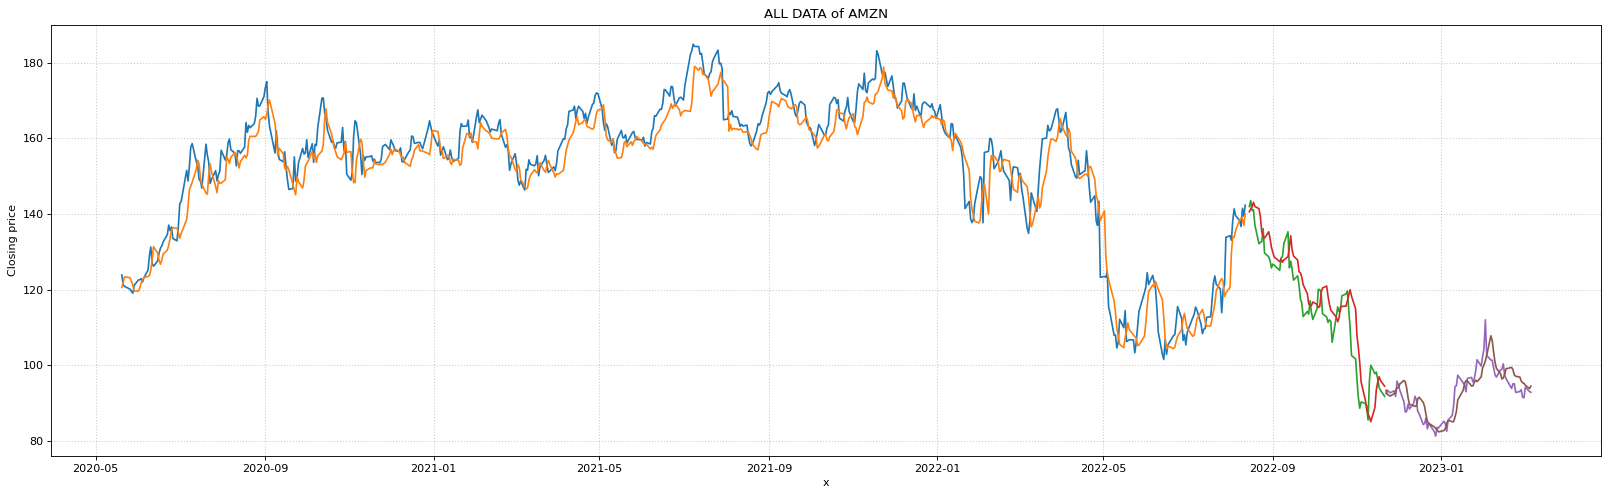

In [8]:
# for the training
pred_ytrain = model.predict(data["xtrain"])
ytrain = data["ytrain"]
# scaler = config["data"]["scaler"]
pred_ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytrain))
ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytrain, axis=0)))


# for the training
pred_yval = model.predict(data["xval"])
yval = data["yval"]
# scaler = config["data"]["scaler"]
pred_yval = np.squeeze(config["data"]["scaler"].inverse_transform(pred_yval))
yval = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(yval, axis=0)))


# for the training
pred_ytest = model.predict(data["xtest"])
ytest = data["ytest"]
# scaler = config["data"]["scaler"]
pred_ytest = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytest))
ytest = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytest, axis=0)))


# ALL 3 TOGETHER
# plot the results
fig= plt.figure(figsize=(25, 7), dpi=80)
# for the training
plt.plot(data["trainDates"],ytrain) # train data
plt.plot(data["trainDates"], pred_ytrain)
plt.plot(data["valDates"], yval) # val data
plt.plot(data["valDates"], pred_yval)
plt.plot(data["testDates"], ytest) # test data
plt.plot(data["testDates"], pred_ytest)
plt.title(f"All of the data from {config['data']['ticker']} with its predictions")
plt.xlabel("Dates")
plt.ylabel("Closing price")
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
plt.show()